In [568]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# 1. Read audio

In [569]:
# Đọc tệp âm thanh .wav từ file đã tải lên
file_path = '../data/i_voice.wav'
data, sampling_rate = librosa.load(file_path, sr=None, mono=True)

# 2. Remove silent frames

In [570]:
def remove_silent_frames(data: np.ndarray, threshold=0.005, frame_length=30, hop_size=15) -> np.ndarray:
    # Tính RMSE
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_size, center=True)

    # Tạo danh sách các frame mà RMSE >= ngưỡng
    valid_frames = np.where(rmse[0] >= threshold)[0]

    # Nếu không có frame nào thỏa mãn, trả về mảng trống
    if len(valid_frames) == 0:
        return []

    # Tính các chỉ số sample tương ứng với các frame đầu và cuối hợp lệ
    start_sample_index = librosa.frames_to_samples(valid_frames[0], hop_length=hop_size)
    end_sample_index = librosa.frames_to_samples(valid_frames[-1] + 1, hop_length=hop_size)

    print(f"Start sample index: {start_sample_index}")
    print(f"End sample index: {end_sample_index}")

    # Trả về đoạn âm thanh sau khi loại bỏ các frame không hợp lệ
    return data[start_sample_index:end_sample_index]

In [571]:
signal_segment = remove_silent_frames(data)

Start sample index: 1725
End sample index: 13665


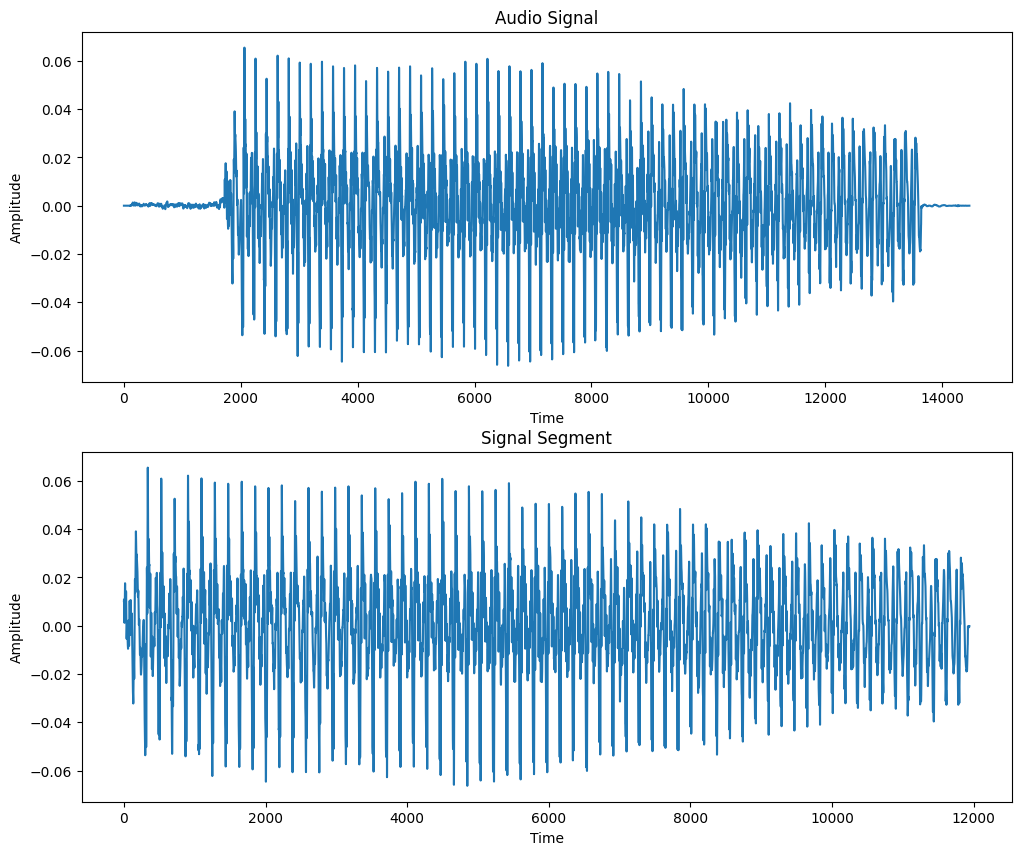

In [572]:
# Plot tín hiệu âm thanh
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Audio Signal')

plt.subplot(2, 1, 2)
plt.plot(signal_segment)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal Segment')
plt.show()

# 3. Find F0 using HPS

In [573]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import find_peaks

def hps(x: np.ndarray, sampling_rate: int, max_harmonics: int=3, max_freq: int=1000):
    """Tìm tần số cơ bản bằng phương pháp Harmonic Product Spectrum (HPS) và vẽ phổ hài."""

    # Tính biến đổi Fourier
    N = len(x)
    T = 1.0 / sampling_rate
    yf = fft(x)
    xf = fftfreq(N, T)[:N//2]
    amplitude_spectrum = 2.0 / N * np.abs(yf[:N//2])

    # Giới hạn phổ dưới max_freq (1kHz)
    mask = xf < max_freq
    xf = xf[mask]
    amplitude_spectrum = amplitude_spectrum[mask]

    # Khởi tạo phổ HPS với phổ FFT đầu tiên
    hps_spectrum = amplitude_spectrum.copy()

    # Tạo figure để vẽ
    plt.figure(figsize=(12, max_harmonics * 4))
    
    # Vẽ phổ gốc
    plt.subplot(max_harmonics+1, 1, 1)
    plt.plot(xf, amplitude_spectrum)
    plt.title("Amplitude Spectrum of Original Signal")
    plt.xlabel("Tần số (Hz)")
    plt.ylabel("Biên độ")
    
    # Nhân phổ với các bội số hài
    for i in range(2, max_harmonics + 1):
        harmonic_spectrum = np.zeros_like(amplitude_spectrum)
        # Chỉ số cho phổ hài
        harmonic_index = np.arange(0, len(amplitude_spectrum))
        # Chỉ số bội số hài
        harmonic_index = harmonic_index * i
        # Giới hạn chỉ số để tránh vượt quá kích thước của phổ
        harmonic_index = harmonic_index[harmonic_index < len(amplitude_spectrum)]
        harmonic_spectrum[harmonic_index.astype(int)] = amplitude_spectrum[harmonic_index.astype(int)]
        
        # Nhân phổ HPS với phổ hài
        hps_spectrum *= harmonic_spectrum
        hps_spectrum /= np.max(hps_spectrum)  # Chuẩn hóa về giá trị lớn nhất là 1

        # Vẽ phổ hài
        plt.subplot(max_harmonics+1, 1, i)
        plt.plot(xf, harmonic_spectrum)
        plt.title(f"Harmonic {i} Spectrum")
        plt.xlabel("Tần số (Hz)")
        plt.ylabel("Biên độ")

    # Vẽ phổ HPS cuối cùng
    plt.subplot(max_harmonics+1, 1, max_harmonics + 1)
    plt.plot(xf, hps_spectrum)
    plt.title("HPS Spectrum")
    plt.xlabel("Tần số (Hz)")
    plt.ylabel("Biên độ")

    plt.tight_layout()
    plt.show()
    
    # Tìm tần số có biên độ cao nhất trong phổ HPS
    peak_index = np.argmax(hps_spectrum)
    f0 = xf[peak_index]

    return f0, xf, hps_spectrum


In [574]:
# Tìm tần số cơ bản (F0) bằng phương pháp Harmonic Product Spectrum (HPS)
f0_hps, xf, hps_spectrum = hps(signal_segment, sampling_rate, max_harmonics=2)

In [ ]:
# Đặt ngưỡng height dựa trên tỷ lệ cực đại
max_height = np.max(hps_spectrum)
height_threshold = 0.1 * max_height # 10%

# Dựa trên tần số và độ phân giải tần số của FFT, tự động thay đổi distance
# Khoảng cách tỷ lệ nghịch với tần số, tần số cao sẽ có khoảng cách ngắn hơn
freq_resolution = sampling_rate / len(xf)  # Độ phân giải tần số của FFT

distance_threshold = int(1500 / freq_resolution)  # Chọn một hệ số ước lượng phù hợp
                        # Phụ thuộc vào tín hiệu 
                        
# Tìm các đỉnh trong phổ HPS
peaks, _ = find_peaks(hps_spectrum, height=height_threshold, distance=distance_threshold)

if len(peaks) == 0:
    raise ValueError("Không tìm thấy đỉnh nào trong phổ HPS!")

# Giới hạn đỉnh trong khoảng dưới 1kHz
peaks_under_1kHz = peaks[xf[peaks] < 1000]

if len(peaks_under_1kHz) == 0:
    raise ValueError("Không có đỉnh nào dưới ngưỡng 1kHz!")

# In top 5 tần số và biên độ tương ứng
for i, idx in enumerate(peaks_under_1kHz, start=1):
    print(f"Đỉnh {i}: F0 = {xf[idx]:.2f} Hz, Biên độ = {hps_spectrum[idx]:.4f}")

Đỉnh 1: F0 = 257.01 Hz, Biên độ = 1.0000
Đỉnh 2: F0 = 412.58 Hz, Biên độ = 0.5801
Đỉnh 3: F0 = 510.34 Hz, Biên độ = 0.9367
Đỉnh 4: F0 = 765.77 Hz, Biên độ = 0.2263


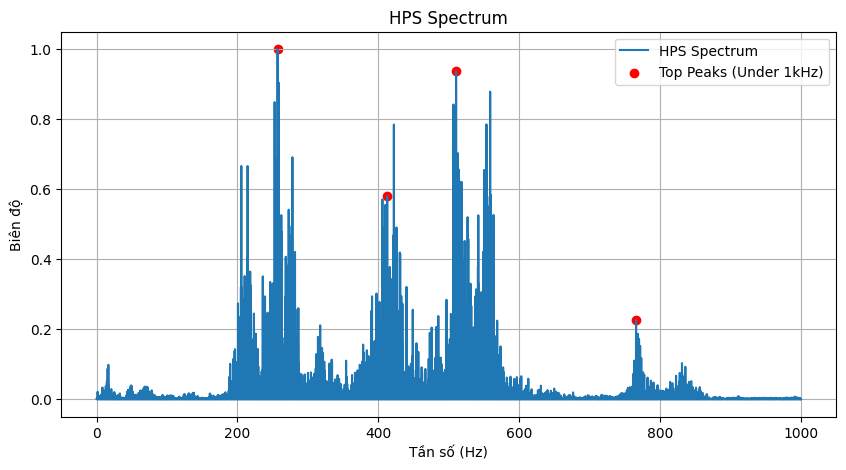

In [ ]:
plt.figure(figsize=(10, 5))

# Vẽ phổ HPS
plt.plot(xf, hps_spectrum, label='HPS Spectrum')
plt.scatter(xf[peaks_under_1kHz], hps_spectrum[peaks_under_1kHz], color='r', label='Top Peaks (Under 1kHz)')  # Đánh dấu top 5 đỉnh
plt.xlabel('Tần số (Hz)')
plt.ylabel('Biên độ')
plt.title('HPS Spectrum')
plt.grid()
plt.legend()